## Import dependencies and data

This is the Jupyter Notebook we used to set up the AI behind "You OK Friend?".

We used the following libraries:

- pytorch version 2.1.0
- numpy version 1.26.0
- pandas version 2.1.1
- matplotlib version 3.8.0
- datasets version 2.14.6
- sklearn version 1.3.2
- huggingface transformers version 4.32.1

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report

# start importing the dataset
dirname = os.getcwd()
for dirname, _, filenames in os.walk('Datasets'):
    for filename in filenames:
        print("Files found: " + os.path.join(dirname, filename))
df = pd.read_csv("Datasets/Suicide_Detection.csv").iloc[:1000] # not all the data, because it yields bad results

# shuffle data
df = shuffle(df)


Files found: Datasets\Suicide_Detection.csv


## Data exploration

      Unnamed: 0                                               text  \
2235        3345  This loneliness...This loneliness is just so b...   
4672        7014  I just wanted to say thanksThank you for all t...   
1105        1641  West Virginia has coal, opioids, and the worst...   
1966        2939  Im bored  filler   filler   filler   filler   ...   
1799        2684  Parents continually telling me to "try harder"...   

            class  
2235      suicide  
4672      suicide  
1105  non-suicide  
1966  non-suicide  
1799      suicide  

This loneliness.... This loneliness is just so bad, like I said in a post before why should I feel this way? Well it's getting worse, I want this pain to stop and maybe... maybe doing this might end this pain. I feel so unimportant and useless and this loneliness is making me shake so much. I don't know what to do...


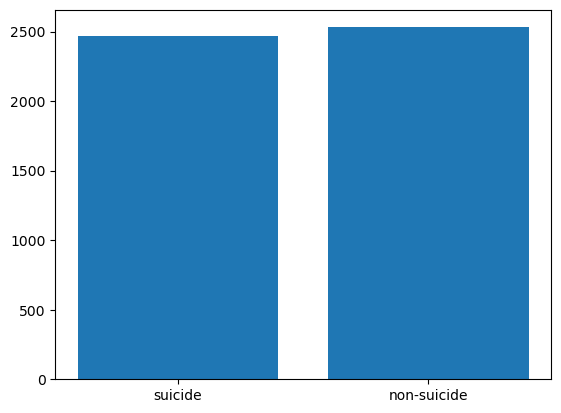

C:\Program_Files\Anaconda3\envs\appmattmidas\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [2]:
# see if there is anything in the dataset
# print(df.info)
print(df.head())

# print one text as a whole
# print(f'\n{df["text"][0]}')

# as we can see, the title and text are not seperated by a space. Let's fix that.
# note: for now only works if body starts with capital letter
# TODO: remove hyperlinks, \n, summary dots, emoji's
for j in range(len(df["text"])):
    for i in range(len(df["text"][j])):
        if i!=0:
            if df["text"][j][i].isupper() and df["text"][j][i-1]!=" ":
                df.loc[j,"text"] = df.loc[j,"text"][:i] + '. ' + df.loc[j,"text"][i:]
                break

# check if it worked
print(f'\n{df.iloc[0].text}')

# check if there is an even distrubution of suicidal and non-suicidal cases
plt.bar(["suicide","non-suicide"],[df['class'].value_counts()['suicide'],df['class'].value_counts()['non-suicide']])
plt.show()

# convert class to label
le = preprocessing.LabelEncoder()
le.fit(df["class"].tolist())
df['label'] = le.transform(df["class"].tolist())
# print(df.head())

# split dataset in train and test
df_train,df_test = train_test_split(df,test_size=0.2)

# convert to Huggingface Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# convert to tokens
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

## AI code

In [3]:
# initialise model based on bert
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# setup train model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# start training and save when done
retrain = True
if retrain:
    trainer.train()
    trainer.save_model('modelv0.1')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Midas\AppData\Local\Temp\ipykernel_16652\286164358.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.451600,0.655942,0.527000
2,0.456300,0.393909,0.885000
3,0.388900,0.348143,0.898000
4,0.280900,0.319857,0.917000
5,0.226600,0.292646,0.917000


In [4]:
if retrain:
    # evluate model on training data
    preds = trainer.predict(tokenized_train)
    preds = np.argmax(preds[:3][0],axis=1)
    GT = df_train['label'].tolist()
    print(classification_report(GT,preds))

    # evaluate model on test data
    preds = trainer.predict(tokenized_test)
    preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
    GT = df_test['label'].tolist()
    print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2004
           1       0.94      0.96      0.95      1996

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



              precision    recall  f1-score   support

           0       0.93      0.91      0.92       527
           1       0.90      0.93      0.91       473

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [5]:
# experiment how to input text and predict on the model
sampletext = '''Hey my name is Midas and lately i've been feeling down. I don't seem to be interested in my hobbies 
like I used to. I'm worried I will end up alone and collapse under the loneliness. What if I'll harm myself in the long run?
Should I seek help or am I just overreacting?
'''
sampletext2 = '''If you're happy and you know it clap your hands
If you're happy and you know it clap your hands
If you're happy and you know it and you really want to show it
If you're happy and you know it clap your hands
'''
sampletext3 = '''Hey how are you doing, i'm not gonna do anything to myself but i need your help. I'm doing great btw
My kid just beat cancer, probably.
'''

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# load model
model = AutoModelForSequenceClassification.from_pretrained("./modelv0.1")
# initialize pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# input text and print the prediction
def predict(text):
    pred = classifier(text)[0]
    if pred["label"] == 'LABEL_0':
        return f'It\'s probably non-suicial, I\'m {round(pred["score"]*100,2)}% sure'
    if pred["label"] == 'LABEL_1':
        return f'It\'s probably suicial, I\'m {round(pred["score"]*100,2)}% sure'
    
print(sampletext3)
print(predict(sampletext3))

Hey how are you doing, i'm not gonna do anything to myself but i need your help. I'm doing great btw
My kid just beat cancer, probably.

It's probably non-suicial, I'm 95.51% sure
